<div style="width: 100%; clear: both;">
<div style="float: left; width: 50%;">
<img src="http://www.uoc.edu/portal/_resources/common/imatges/marca_UOC/UOC_Masterbrand.jpg", align="left">
</div>
<div style="float: right; width: 50%;">
<p style="margin: 0; padding-top: 22px; text-align:right;">M2.875 · Deep Learning · PEC1</p>
<p style="margin: 0; text-align:right;">2022-2 · Máster universitario en Ciencia de datos (Data science)</p>
<p style="margin: 0; text-align:right; padding-button: 100px;">Estudios de Informática, Multimedia y Telecomunicación</p>
</div>
</div>
<div style="width:100%;">&nbsp;</div>


# PEC 1: Redes neuronales artificiales y convolucionales con Keras

A lo largo de esta práctica vamos a implementar varios modelos de redes neuronales para clasificar las imágenes de una base de datos de imágenes satelitales. En concreto:
- Se implementará una red completamente conectada para establecer un modelo de referencia o <i>baseline</i>
- Se implementará una red convolucional
- Se implementará un autoencoder
- Se implementará una red convolucional profunda a partir de un modelo conocido (VGG16) pre-entrenado en Imagenet utilizando <i>transfer-learning</i>

<u>Consideraciones generales</u>: 

- La solución planteada no puede utilizar métodos, funciones o parámetros declarados **_deprecated_** en futuras versiones, a excepción de la carga de datos cómo se indica posteriormente.
- Esta PEC debe realizarse de forma **estrictamente individual**. Cualquier indicio de copia será penalizado con un suspenso (D) para todas las partes implicadas y la posible evaluación negativa de la asignatura de forma íntegra.
- Es necesario que el estudiante indique **todas las fuentes** que ha utilizado para la realización de la PEC. De no ser así, se considerará que el estudiante ha cometido plagio, siendo penalizado con un suspenso (D) y la posible evaluación negativa de la asignatura de forma íntegra.

<u>Formato de la entrega</u>:

- Algunos ejercicios pueden suponer varios minutos de ejecución, por lo que la entrega debe hacerse en **formato notebook** y en **formato html**, donde se vea el código, los resultados y comentarios de cada ejercicio. Se puede exportar el notebook a HTML desde el menú File $\to$ Download as $\to$ HTML.
- Existe un tipo de celda especial para albergar texto. Este tipo de celda os será muy útil para responder a las diferentes preguntas teóricas planteadas a lo largo de la actividad. Para cambiar el tipo de celda a este tipo, en el menú: Cell $\to$ Cell Type $\to$ Markdown.

## 0. Contexto y carga de librerías
Las imágenes tomadas por satélite son clave en la supervisión del uso y la cobertura del suelo, cuestiones relevantes para la gestión ambiental, la planificación urbana, la sostenibilidad y para combatir el cambio climático.

En esta práctica, trabajaremos con la base de datos [UC Merced Land Use Data](http://weegee.vision.ucmerced.edu/datasets/landuse.html), que consiste en imágenes satelitales de 256x256 píxeles de 21 escenas diferentes: las clases son diversas, conteniendo escenas e imágenes de aviones o ríos, entre otras categorías.

Concretamente trabajaremos con una versión aumentada de dicha base de datos que está disponible en un [repositorio de Kaggle](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification). En esta versión se han llevado a cabo varios procesos de aumentación de datos de tal forma que el número de imágenes por clase pasa de 100 a 500.

**Nota: Se recomienda realizar la práctica en el entorno que ofrece la plataforma Kaggle, ya que ofrece un entorno gratuito con 30 horas semanales de uso de GPU.**

A lo largo de toda la práctica, para la creación de las distintas redes, iremos alternando el uso del modelo [Sequential](https://keras.io/guides/sequential_model/) y el modelo [Functional](https://keras.io/guides/functional_api/) de Keras a través de las clases [Sequential](https://keras.io/api/models/sequential/) y [Model](https://keras.io/api/models/model/) respectivamente.

Empezamos cargando las librerías mas relevantes:

In [1]:
# Importamos tensorflow
import tensorflow as tf
print("TF version   : ", tf.__version__)

# Necesitaremos GPU
print("GPU available: ", tf.config.list_physical_devices('GPU'))

# keras version is 2.11.0
import keras
print("Keras version   : ", keras.__version__)

TF version   :  2.11.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Keras version   :  2.11.0


In [2]:
# Importamos los elementos de keras que utilizaremos con mayor frecuencia
from keras.utils import image_dataset_from_directory
from keras.layers import (
    GlobalAveragePooling2D, Flatten,
    Dense, Dropout, Conv2D, Conv2DTranspose, BatchNormalization, 
    MaxPooling2D, UpSampling2D, Rescaling, Resizing)
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras import Sequential, Model

In [3]:
# Importamos el resto de librerías que necesitaremos para la PEC
import cv2
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time

## 1. Descarga, análisis y pre-procesado de los datos (1,5 puntos)

En este apartado exploraremos la base de datos y prepararemos la carga de las imágenes para los modelos de los siguientes apartados.

Para la descarga de la base de datos tenemos 2 opciones dependiendo de si decidimos trabajar en local o desde el entorno de Kaggle:
- Si trabajamos en local debemos descargar la base de datos desde el siguiente [enlace](https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification/download?datasetVersionNumber=3) (es un archivo .zip que ocupa 2 GB) y descomprimirlo.
- Si trabajamos desde Kaggle. Debemos subir el Notebook del enunciado a la plataforma (para ello podéis seguir los 6 primeros pasos del siguiente [artículo](https://rajputankit22.medium.com/how-to-upload-my-own-notebook-to-kaggle-2b0dedbb5a6b)) y después, una vez subido el notebook, clickar el botón '+ Add Data' y en la caja de búsqueda introducir la dirección 'https://www.kaggle.com/datasets/apollo2506/landuse-scene-classification'. Una vez encontrado el dataset darle al botón '+' (Add Dataset), y desde ese momento ya tendréis accesible la base de datos en la ruta <code>../input/</code>.

Una vez tenemos la base de datos accesible vamos a inspeccionarla.

Las imágenes se encuentran agrupadas de 2 formas diferentes:
- En la carpeta <code>/landuse-scene-classification/images/</code> se encuentra el total de las imágenes separadas por clases (cada clase en una carpeta distinta). Pero no se ha realizado una separación en conjunto de entrenamiento y test (o entrenamiento, validación y test).
- En la carpeta <code>/landuse-scene-classification/images_train_test_val/</code> se encuentran 3 carpetas (<code>test</code>, <code>train</code> y <code>validation</code>) en las que el total de imágenes se ha separado de forma aleatoria. En cada una de las 3 carpetas, tenemos imágenes de las 21 clases agrupadas en sus correspondientes carpetas. En la carpeta raíz <code>/landuse-scene-classification/</code> tenemos 3 archivos .csv con la distribución de cada carpeta.

En esta práctica utilizaremos el dataset ya particionado, es decir, trabajaremos con las imágenes que se encuentran en la ruta <code>/landuse-scene-classification/images_train_test_val/</code>.

### 1.1. Análisis de los archivos .csv

A partir de los archivos .csv podemos ver cómo se han distribuído los datos. Por ejemplo:

In [4]:
train = pd.read_csv('../input/landuse-scene-classification/train.csv')
train.head(5)

Unnamed: 0                              Filename  Label     ClassName
0        5818              runway/runway_000259.png     16        runway
1        1327  intersection/intersection_000348.png     10  intersection
2        2529  agricultural/agricultural_000025.png      0  agricultural
3        3865        chaparral/chaparral_000195.png      5     chaparral
4        2024          airplane/airplane_000260.png      1      airplane

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio [0,5 pts.]:</strong> A partir de los 3 archivos .csv se pide:
    <ul>
        <li>Extraer los nombres de las 21 clases (esto sólo hace falta hacerlo en uno de los 3 archivos)</li>
        <li>¿Cuántas instancias tenemos en total para cada conjunto de datos?</li>
        <li>Comprobar que las clases están balanceadas en los 3 conjuntos de datos (contando para cada conjunto, cuantas instancias/ejemplos tenemos para cada clase)</li>
    </ul>        
</div>

In [5]:
# Estraer nombres de las clases
class_names = train['ClassName'].unique()
print('Las nombres de las clases son:')
for name in class_names:
    print(name)

Las nombres de las clases son:
runway
intersection
agricultural
chaparral
airplane
storagetanks
tenniscourt
overpass
harbor
buildings
mediumresidential
baseballdiamond
golfcourse
freeway
sparseresidential
river
mobilehomepark
forest
beach
parkinglot
denseresidential


In [6]:
# Número de instancias por conjunto

val = pd.read_csv('../input/landuse-scene-classification/validation.csv')
test = pd.read_csv('../input/landuse-scene-classification/test.csv')

print('Número de instancias para entrenamiento = {}'.format(train.shape[0]))
print('Número de instancias para validación = {}'.format(val.shape[0]))
print('Número de instancias para test = {}'.format(test.shape[0]))

Número de instancias para entrenamiento = 7350
Número de instancias para validación = 2100
Número de instancias para test = 1050


In [7]:
# Número de instancias por clase

print('Para el conjunto de datos de entrenamiento tenemos:')
train.groupby('ClassName').size()


Para el conjunto de datos de entrenamiento tenemos:


ClassName
agricultural         350
airplane             350
baseballdiamond      350
beach                350
buildings            350
chaparral            350
denseresidential     350
forest               350
freeway              350
golfcourse           350
harbor               350
intersection         350
mediumresidential    350
mobilehomepark       350
overpass             350
parkinglot           350
river                350
runway               350
sparseresidential    350
storagetanks         350
tenniscourt          350
dtype: int64

In [8]:
print('Para el conjunto de datos de validación tenemos:')
val.groupby('ClassName').size()

Para el conjunto de datos de validación tenemos:


ClassName
agricultural         100
airplane             100
baseballdiamond      100
beach                100
buildings            100
chaparral            100
denseresidential     100
forest               100
freeway              100
golfcourse           100
harbor               100
intersection         100
mediumresidential    100
mobilehomepark       100
overpass             100
parkinglot           100
river                100
runway               100
sparseresidential    100
storagetanks         100
tenniscourt          100
dtype: int64

In [9]:
print('Para el conjunto de datos de test tenemos:')
test.groupby('ClassName').size()

Para el conjunto de datos de test tenemos:


ClassName
agricultural         50
airplane             50
baseballdiamond      50
beach                50
buildings            50
chaparral            50
denseresidential     50
forest               50
freeway              50
golfcourse           50
harbor               50
intersection         50
mediumresidential    50
mobilehomepark       50
overpass             50
parkinglot           50
river                50
runway               50
sparseresidential    50
storagetanks         50
tenniscourt          50
dtype: int64

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Como podemos ver, la base de datos está perfectamente balanceada ya que tiene el mismo número de instancias para cada clase en cada uno de los conjuntos:
    <ul>
        <li> El conjunto de entrenamiento dispone de 7350 instancias (350 para cada clase)</li>
        <li> El conjunto de validación dispone de 2100 instancias (100 para cada clase)</li>
        <li> El conjunto de test dispone de 1050 instancias (50 para cada clase)</li>
    </ul>
</div>

### 1.2. Análisis de las carpetas de imágenes.

Aunque se supone que cada archivo .csv refleja a la perfección el contenido de cada conjunto de datos, no está demás cerciorarse que el contenido del mismo se corresponde con lo anotado en cada archivo. Para ello se pide:

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Proporciona, a partir de las carpetas de imágenes, el número de imágenes que tenemos en cada categoría para cada conjunto de datos, comprobando que coincide con lo estipulado en el archivo .csv, y visualiza a modo de ejemplo una imagen por cada categoría. ¿Qué rango dinámico (valores mínimo y máximo) tienen las imágenes?
</div>

Category -- Number of Images
airplane	350
tenniscourt	350
river	350
denseresidential	350
parkinglot	350
storagetanks	350
overpass	350
sparseresidential	350
mediumresidential	350
intersection	350
baseballdiamond	350
runway	350
chaparral	350
freeway	350
beach	350
buildings	350
harbor	350
mobilehomepark	350
forest	350
golfcourse	350
agricultural	350

Random visualization


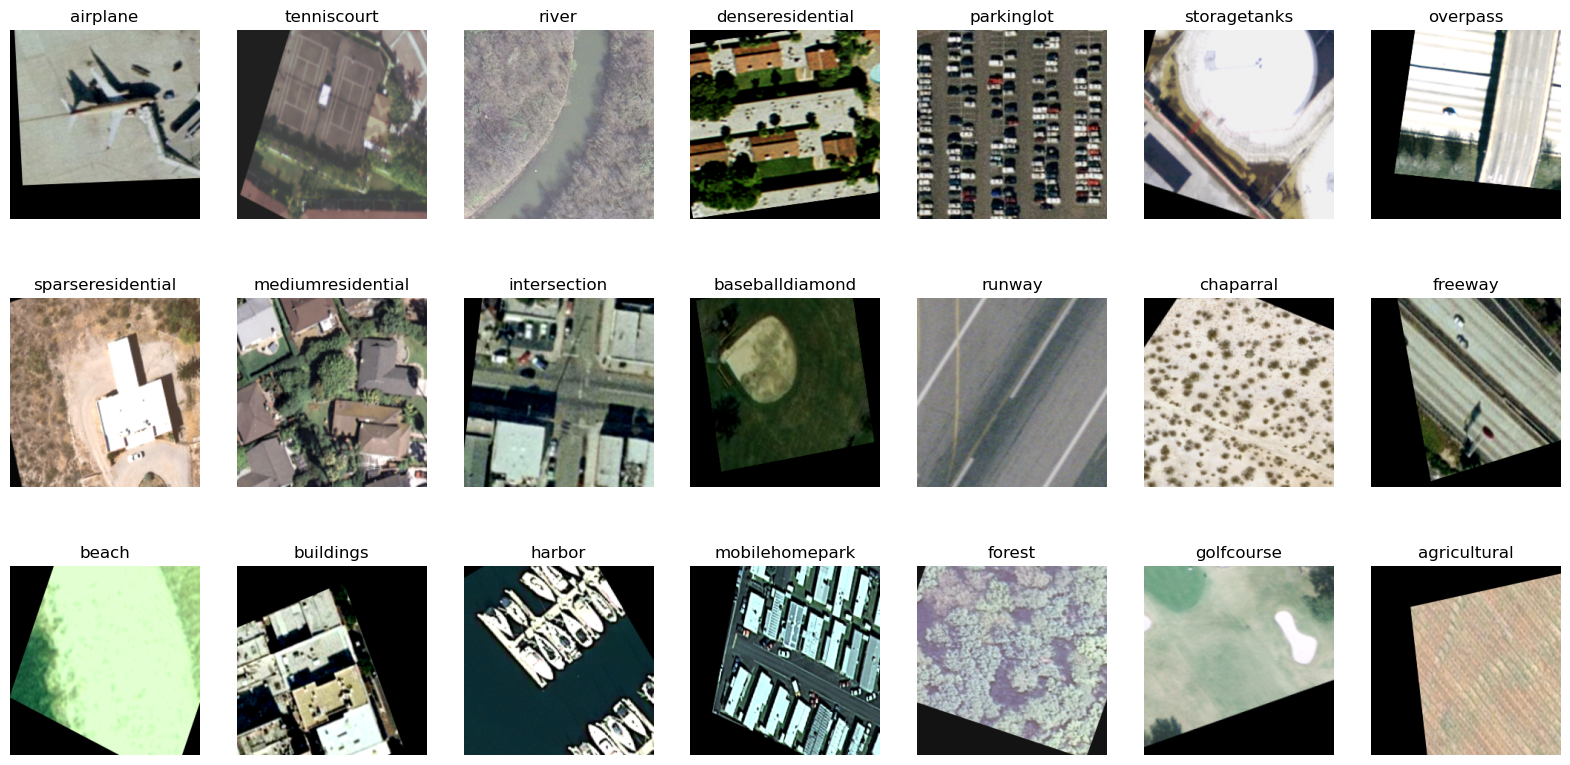

Dinamic range 0 254 uint8


In [10]:
# Para el conjunto de datos de entrenamiento

path_data = "../input/landuse-scene-classification/images_train_test_val/train/"
list_images = glob.glob(os.path.join(path_data, "*/*.png"))
categories = os.listdir(path_data)

plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.5)

print("=============================")
print("Category -- Number of Images")
print("=============================")
for i, c in enumerate(categories):
    selected = [filename for filename in list_images if c in filename]
    np.random.shuffle(selected)
    print("{}\t{}".format(c,len(selected)))

    img = cv2.imread(selected[0])
    plt.subplot(3,7, 1+i), plt.imshow(img[:,:,::-1])
    plt.title(c)
    plt.axis('off')

print()
print("=============================")
print("Random visualization")
print("=============================")
plt.show()

print("Dinamic range", img.min(), img.max(), img.dtype)

Category -- Number of Images
airplane	100
tenniscourt	100
river	100
denseresidential	100
parkinglot	100
storagetanks	100
overpass	100
sparseresidential	100
mediumresidential	100
intersection	100
baseballdiamond	100
runway	100
chaparral	100
freeway	100
beach	100
buildings	100
harbor	100
mobilehomepark	100
forest	100
golfcourse	100
agricultural	100

Random visualization


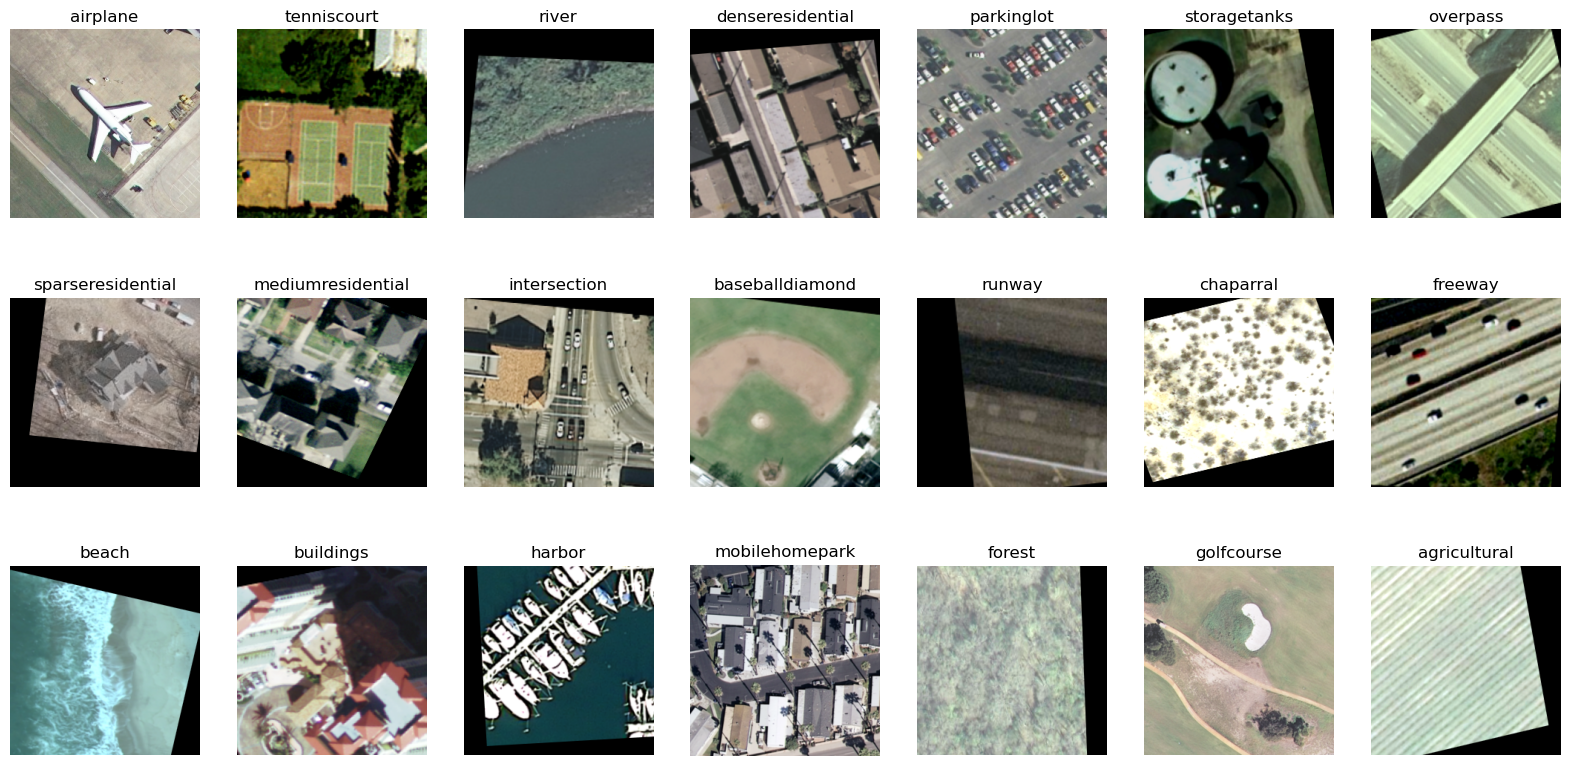

Dinamic range 0 255 uint8


In [11]:
# Para el conjunto de datos de validación

path_data = "../input/landuse-scene-classification/images_train_test_val/validation/"
list_images = glob.glob(os.path.join(path_data, "*/*.png"))
categories = os.listdir(path_data)

plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.5)

print("=============================")
print("Category -- Number of Images")
print("=============================")
for i, c in enumerate(categories):
    selected = [filename for filename in list_images if c in filename]
    np.random.shuffle(selected)
    print("{}\t{}".format(c,len(selected)))

    img = cv2.imread(selected[0])
    plt.subplot(3,7, 1+i), plt.imshow(img[:,:,::-1])
    plt.title(c)
    plt.axis('off')

print()
print("=============================")
print("Random visualization")
print("=============================")
plt.show()

print("Dinamic range", img.min(), img.max(), img.dtype)

Category -- Number of Images
airplane	50
tenniscourt	50
river	50
denseresidential	50
parkinglot	50
storagetanks	50
overpass	50
sparseresidential	50
mediumresidential	50
intersection	50
baseballdiamond	50
runway	50
chaparral	50
freeway	50
beach	50
buildings	50
harbor	50
mobilehomepark	50
forest	50
golfcourse	50
agricultural	50

Random visualization


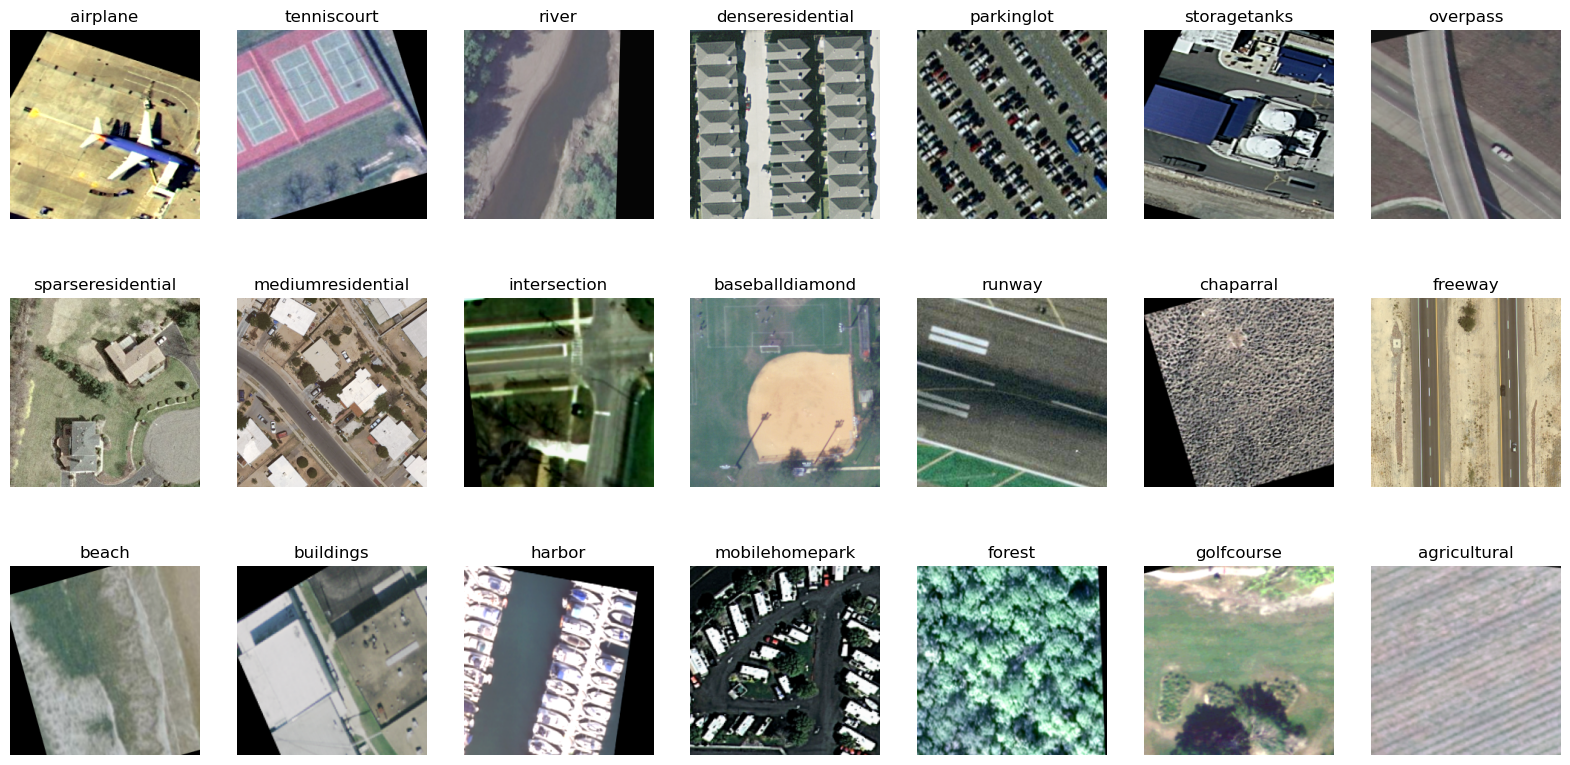

Dinamic range 26 228 uint8


In [12]:
# Para el conjunto de datos de test

path_data = "../input/landuse-scene-classification/images_train_test_val/test/"
list_images = glob.glob(os.path.join(path_data, "*/*.png"))
categories = os.listdir(path_data)

plt.figure(figsize=(20,20))
plt.subplots_adjust(bottom=0.5)

print("=============================")
print("Category -- Number of Images")
print("=============================")
for i, c in enumerate(categories):
    selected = [filename for filename in list_images if c in filename]
    np.random.shuffle(selected)
    print("{}\t{}".format(c,len(selected)))

    img = cv2.imread(selected[0])
    plt.subplot(3,7, 1+i), plt.imshow(img[:,:,::-1])
    plt.title(c)
    plt.axis('off')

print()
print("=============================")
print("Random visualization")
print("=============================")
plt.show()

print("Dinamic range", img.min(), img.max(), img.dtype)

### 1.3. Creación de los conjuntos de datos en formato Keras/Tensorflow

Con el objetivo de crear una base de datos en el formato Keras/Tensorflow a partir de las imágenes proporcionadas utilizaremos la función <code>**tf.keras.utils.image_dataset_from_directory()**</code> ya que nos permite crear bases de datos a partir de imágenes guardadas en carpetas.

La documentación de esta función se encuentra tanto en la web de [Keras](https://keras.io/api/data_loading/image/) como en la de [Tensorflow](https://www.tensorflow.org/api_docs/python/tf/keras/utils/image_dataset_from_directory) .

Además, aprovecharemos para redimensionar las imágenes y pasarlas a tamaño 224x224, que es el tamaño con el que se ha entrenado la red VGG16 que utilizaremos en un apartado posterior.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[0,5 pts]:</strong> Utiliza la función  <code>image_dataset_from_directory()</code> para generar 3 conjuntos de datos (<code>train_data</code>, <code>val_data</code> y <code>test_data</code>) a partir de las carpetas analizadas. Las imágenes deben ser redimensionadas a tamaño 224x224 píxels RGB (224,224,3) y agrupadas en lotes de tamaño 32 (batch=32) manteniendo su rango dinámico.
</div>

In [13]:
train_dir = "../input/landuse-scene-classification/images_train_test_val/train"
val_dir = "../input/landuse-scene-classification/images_train_test_val/validation"
test_dir = "../input/landuse-scene-classification/images_train_test_val/test"

In [14]:
train_data = image_dataset_from_directory(train_dir,
                                         labels="inferred",
                                         label_mode="categorical",
                                         image_size=(224, 224))
val_data = image_dataset_from_directory(val_dir,
                                         labels="inferred",
                                         label_mode="categorical",
                                         image_size=(224, 224))
test_data = image_dataset_from_directory(test_dir,
                                         labels="inferred",
                                         label_mode="categorical",
                                         image_size=(224, 224))

Found 7350 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.


## 2. Modelo ANN (1,5 puntos)

En este apartado, vamos a entrenar y evaluar un modelo muy sencillo completamente conectado para establecer un resultado de referencia.

Dado que en una red neuronal artificial las entradas son unidimensionales, lo primero que tenemos que hacer es redimensionar los datos de entrada (las imágenes) para convertirlos en arrays de una dimensión.

Como trabajar con imágenes de tamaño 224x224 en una red completamente conectada implicaría entrenar un número de parámetros excesivamente elevado definiremos un modelo en el que se realizará previamente un redimensionado de las imágenes de entrada a un tamaño de 32x32 y un achatamiento (*flattening*) de los píxeles para así generar un vector unidimensional de tamaño 3072 (32x32x3). 

Posteriormente entrenaremos un clasificador (una red completamente conectada) para llevar a cabo la clasificación de nuestros datos.

En este apartado utilizaremos las capas [Resizing](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/resizing/), [Rescaling](https://keras.io/api/layers/preprocessing_layers/image_preprocessing/rescaling/), [Flatten](https://keras.io/api/layers/reshaping_layers/flatten/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio:</strong> Implementa un modelo <strong>secuencial</strong> de Keras (a partir de la clase <code>Sequential()</code>) con las siguientes especificaciones:
    <ul>
        <li>Una capa que reduzca las dimensiones de entrada de (224,224) a (32,32)</li>
        <li>Una capa de reescalado para conseguir que los valores de la imagen estén entre 0 y 1</li>
        <li>Una capa Flatten para convertir la imagen en un vector de 3072 posiciones</li>
        <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
        <li>Una capa de Dropout (con probabilidad 0.5)</li>
        <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
    </ul>
        
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación. NOTA: Se recomienda hacer una función que imprima ambas gráficas para poder reutilizarla en próximos apartados.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.<br/>    
    <strong> NOTA: se recomienda, al final de la creación de cada modelo, utilizar la función <code>summary()</code> para comprobar la estructura de la red creada, así como el numero de parámetros que se deben entrenar. Se recomienda hacerlo en todos los ejercicios.</strong>
</div>

In [15]:
# Definición de la red
ann_model = Sequential()

ann_model.add(Resizing(32,32,input_shape=(224,224,3)))
ann_model.add(Rescaling(1./255))
ann_model.add(Flatten())
ann_model.add(Dense(1024, activation="relu"))
ann_model.add(Dense(21, activation="softmax"))

ann_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 3)         0         
                                                                 
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 flatten (Flatten)           (None, 3072)              0         
                                                                 
 dense (Dense)               (None, 1024)              3146752   
                                                                 
 dense_1 (Dense)             (None, 21)                21525     
                                                                 
Total params: 3,168,277
Trainable params: 3,168,277
Non-trainable params: 0
_________________________________________________________________


In [16]:
# Compilación de la red
opt = Adam(learning_rate=0.0001)

ann_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10, 
                            verbose=1, 
                            restore_best_weights=True)

In [17]:
# Entrenamiento de la red
t = time.time()
ann_history = ann_model.fit(train_data,
                            epochs=100,
                            callbacks=[stopping],
                            verbose=1,
                            validation_data=val_data)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
230/230 [==============================] - 46s 185ms/step - loss: 3.0523 - accuracy: 0.0804 - val_loss: 3.0067 - val_accuracy: 0.0986
Epoch 2/100
230/230 [==============================] - 31s 130ms/step - loss: 2.8837 - accuracy: 0.1271 - val_loss: 2.9646 - val_accuracy: 0.0938
Epoch 3/100
230/230 [==============================] - 26s 109ms/step - loss: 2.7726 - accuracy: 0.1687 - val_loss: 2.8786 - val_accuracy: 0.1319
Epoch 4/100
230/230 [==============================] - 30s 129ms/step - loss: 2.6894 - accuracy: 0.2007 - val_loss: 2.8315 - val_accuracy: 0.1590
Epoch 5/100
230/230 [==============================] - 26s 109ms/step - loss: 2.6169 - accuracy: 0.2184 - val_loss: 2.8159 - val_accuracy: 0.1757
Epoch 6/100
230/230 [==============================] - 25s 108ms/step - loss: 2.5331 - accuracy: 0.2547 - val_loss: 2.8003 - val_accuracy: 0.1624
Epoch 7/100
230/230 [==============================] - 30s 127ms/step - loss: 2.4841 - accuracy: 0.2654 - val_loss: 2.7716 -

In [18]:
# Plot del training loss i l'accuracy
def plot_training(n_epochs, mfit):
    N = n_epochs
    plt.style.use("ggplot")
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
    fig.suptitle('Training Loss and Accuracy')
    
    ax1.plot(np.arange(0, N), mfit.history["accuracy"], label="train")
    ax1.plot(np.arange(0, N), mfit.history["val_accuracy"], label="val")
    ax1.set_title("Accuracy")
    ax1.set_xlabel("Epoch #")
    ax1.set_ylabel("Accuracy")
    ax1.legend(loc="lower right")
    
    ax2.plot(np.arange(0, N), mfit.history["loss"], label="train")
    ax2.plot(np.arange(0, N), mfit.history["val_loss"], label="val")
    ax2.set_title("Loss")
    ax2.set_xlabel("Epoch #")
    ax2.set_ylabel("Loss")
    ax2.legend(loc="upper right")
    
    plt.show()

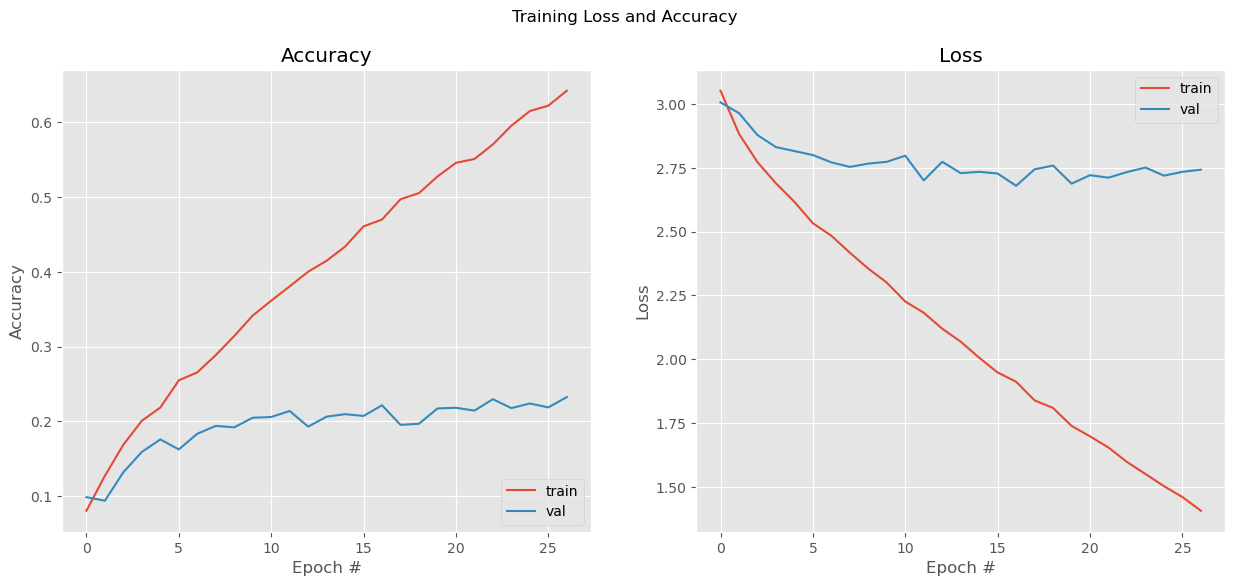

----------
Loss: 2.711120
Accuracy: 0.216190


In [19]:
n_epochs = len(ann_history.history["loss"])
plot_training(n_epochs, ann_history)

score = ann_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Los resultados obtenidos son:
    <ul>
        <li> Número de parámetros a entrenar: 3,168,277</li>
        <li> Tiempo de entrenamiento: 792 segundos (finaliza en 27 épocas)</li>
        <li> Accuracy: 21.62 %</li>
    </ul>
    Los resultados son muy pobres. El número de parámetros a entrenar es muy elevado comparado con las prestaciones obtenidas. Esto es debido a que el modelo completamente conectado no es capaz de extraer, a partir de los datos proporcionados, las características necesarias para realizar una correcta clasificación.
</div>

## 3. Red convolucional pequeña (2 puntos)

Dadas las bajas prestaciones del modelo anterior vamos a probar otro tipo de redes con el objetivo de obtener unos mejores resultados en la tarea de clasificación que debemos llevar a cabo.

Las redes convolucionales (CNN) son especialmente adecuadas para modelar datos donde hay patrones en 2 dimensiones, como es el caso de las imágenes.

En la tarea de clasificación, la estructura de una CNN se divide en dos grandes bloques:

* **Bloque extractor de características**: En este bloque se generan diferentes niveles de abstracción de la imagen de entrada mediante capas convolucionales. Cuanto más profundas son estas capas, más preparadas están para la tarea de clasificación.
* **Clasificador**: Este bloque está formado por capas totalmente conectadas, la salida de deste bloque será la probabilidad asociada a cada clase.

En el apartado anterior, el bloque "extractor de características" era extremadamente simple, por no decir inexistente. En este apartado, vamos a hacer uso de capas convolucionales para poder aprender mejores abstracciones de las imágenes de entrada con el fin de mejorar su clasificación.

En este apartado utilizaremos las capas [Conv2D](https://keras.io/api/layers/convolution_layers/convolution2d/),  [MaxPooling2D](https://keras.io/api/layers/pooling_layers/max_pooling2d/), [GlobalAveragePooling2D](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/), [Dense](https://keras.io/api/layers/core_layers/dense/) y [Dropout](https://keras.io/api/layers/regularization_layers/dropout/) de keras.

**Nota: Se recomienda, a partir de este punto realizar el entrenamiento en una máquina con GPU (puede activarse en plataformas como Google Colab o Kaggle) con el fin de reducir los tiempos de entrenamiento.**

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [2 puntos]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa una red con las siguientes características:
    <ul>
        <li>Un bloque extractor de características que conste de:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>Una capa de rescalado para conseguir que los valores de la imagen estén entre 0 y 1.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
                <li>Una capa de <i>average pooling</i> (GlobalAveragePooling2D) para reducir las dimensiones a un vector de 1024 dimensiones.</li>
            </ul></li>
        <li>El clasificador final sigue la estructura del modelo del apartado anterior:
            <ul>
                <li>Una capa completamente conectada de 1024 neuronas y activación ReLU</li>
                <li>Una capa de Dropout (con probabilidad 0.5)</li>
                <li>Una capa de salida completamente conectada correspondiente a la clasificación final cuyo número de neuronas debe ser igual al múmero de clases de la base de datos y con la función de activación adecuada para llevar a cabo esta tarea de clasificación.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
          <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de <i>accuracy</i> y <i>loss</i>. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final sobre los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [20]:
# Definición de la red
# Feature extractor
input_layer = keras.Input(shape=(224, 224, 3), name="image")
x = Rescaling(1./255)(input_layer)
x = Conv2D(16, (5, 5), padding='same', activation="relu", name='conv1')(x)
x = MaxPooling2D()(x)
x = Conv2D(16*2, (3, 3), padding='same', activation="relu", name='conv2')(x)
x = MaxPooling2D()(x)
x = Conv2D(16*4, (3, 3), padding='same', activation="relu", name='conv3')(x)
x = MaxPooling2D((2,2))(x)
x = GlobalAveragePooling2D(name='average')(x)

# Classificator
x = Dense(1024, name='dense1', activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(21, name='classifier', activation="softmax")(x)


cnn_model = keras.Model(input_layer, x, name="model")
cnn_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                         

In [21]:
# Compilación de la red
opt = Adam(learning_rate=0.001)

cnn_model.compile(
    optimizer=opt,
    loss="categorical_crossentropy",
    metrics=["accuracy"])

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10, 
                            verbose=1, 
                            restore_best_weights=True)

In [22]:
# Entrenamiento
t = time.time()
cnn_history = cnn_model.fit(train_data,
                            epochs=100,
                            callbacks=[stopping],
                            verbose=1,
                            validation_data=val_data)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
230/230 [==============================] - 30s 111ms/step - loss: 2.8058 - accuracy: 0.1090 - val_loss: 2.6127 - val_accuracy: 0.1590
Epoch 2/100
230/230 [==============================] - 26s 111ms/step - loss: 2.4618 - accuracy: 0.1956 - val_loss: 2.2960 - val_accuracy: 0.2510
Epoch 3/100
230/230 [==============================] - 26s 111ms/step - loss: 2.2410 - accuracy: 0.2702 - val_loss: 2.0935 - val_accuracy: 0.3081
Epoch 4/100
230/230 [==============================] - 26s 110ms/step - loss: 2.0653 - accuracy: 0.3252 - val_loss: 1.9850 - val_accuracy: 0.3548
Epoch 5/100
230/230 [==============================] - 26s 111ms/step - loss: 1.9342 - accuracy: 0.3721 - val_loss: 1.9108 - val_accuracy: 0.3624
Epoch 6/100
230/230 [==============================] - 26s 110ms/step - loss: 1.8045 - accuracy: 0.4082 - val_loss: 1.7559 - val_accuracy: 0.4267
Epoch 7/100
230/230 [==============================] - 31s 132ms/step - loss: 1.6868 - accuracy: 0.4412 - val_loss: 1.5690 -

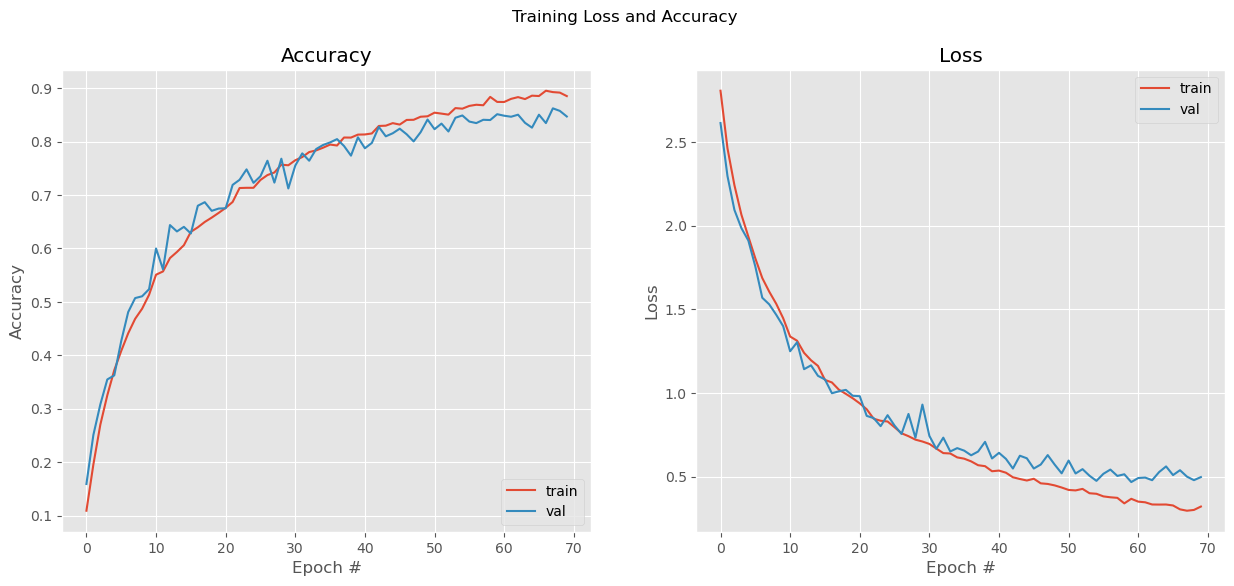

----------
Loss: 0.458473
Accuracy: 0.851429


In [23]:
# Resultados
n_epochs = len(cnn_history.history["loss"])
plot_training(n_epochs, cnn_history)

score = cnn_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Los resultados obtenidos son:
    <ul>
        <li> Número de parámetros a entrenar: 112,437</li>
        <li> Tiempo de entrenamiento: 2,165 segundos (finaliza en 70 épocas)</li>
        <li> Accuracy: 85.14 %</li>
    </ul>
    Los resultados son bastante buenos, las redes convolucionales consiguen captar mucho mejor las características de los datos y, con menos parámetros a entrenar, consiguen mejores resultados.
</div>

## 4. Autoencoders (2 puntos)

En el apartado anterior hemos podido observar que, utilizando el tipo de redes adecuado, podemos obtener mejores resultados entrenando un número de parámetros muy inferior. Esto es debido a que las CNN consiguen extraer las características principales de los datos proporcionados (imágenes en nuestro caso).

En este apartado vamos a observar esta capacidad desde otro punto de vista: el de **codificar y decodificar una imagen**.

Para ello diseñaremos un autoencoder que sea capaz de reducir el tamaño de los datos de entrada pero captando las características principales de las imágenes para poder llevar a cabo una buena reconstrucción de las mismas.

Empezaremos reescalando externamente los datos que vamos a utilizar, para que estén en el rango (0,1), en lugar de realizarlo dentro de la red como hemos hecho en el apartado anterior:

In [24]:
# data rescalling
normalization_layer = Rescaling(1./255)

normalized_train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
normalized_val_data = val_data.map(lambda x, y: (normalization_layer(x), y))

Además, en un autoencoder, en lugar de utilizar las etiquetas como objetivo (que es lo que se utiliza en un problema de clasificación), deben ser las propias imágenes las que se utilicen como objetivo de la red. Por tanto, crearemos una nueva base de datos de entrenamiento y validación donde son las propias imágenes las que hagan de etiquetas:

In [25]:
train_data_auto = normalized_train_data.map(lambda x, y: (x, x))
val_data_auto = normalized_val_data.map(lambda x, y: (x, x))

Comprobamos la estructura de la nueva base de datos:

In [26]:
image_batch, label_batch = iter(train_data_auto).get_next()
print("Las dimensiones de un batch de imágenes es: {}".format(image_batch.shape))
print("Las dimensiones de un batch de etiquetas es: {}".format(label_batch.shape))

Las dimensiones de un batch de imágenes es: (32, 224, 224, 3)
Las dimensiones de un batch de etiquetas es: (32, 224, 224, 3)


Y que los datos tienen el rango dinámico adecuado:

In [27]:
first_image = image_batch[0]
print("En la primera imagen los valores mínimo y máximo son {} y {}, respectivamente"
      .format(np.min(first_image),np.max(first_image)))

En la primera imagen los valores mínimo y máximo son 0.0 y 1.0, respectivamente


### 4.1. Diseño y entrenamiento del autoencoder

Una vez ya tenemos los datos en el formato adecuado vamos a diseñar el autoencoder. Para ello utilizaremos el bloque extractor del apartado anterior como codificador y reflejaremos su estructura en el decodificador utilizando las capas [Conv2DTranspose](https://keras.io/api/layers/convolution_layers/convolution2d_transpose/) y [UpSampling2D](https://keras.io/api/layers/reshaping_layers/up_sampling2d/) de keras.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> A partir del modelo <strong>funcional</strong> de keras (y la clase <code>Model()</code>), implementa un autoencoder con las siguientes características:
    <ul>
        <li>El bloque codificador debe tener:
            <ul>
                <li>Una capa de entrada de dimensiones adecuadas a los datos.</li>
                <li>3 capas convolucionales con tamaño de kernel (5x5) para la primera y (3x3) para las 2 siguientes. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 16, 32 y 64 respectivamente.</li>
                <li>A cada capa convolucional le sigue una capa de <i>Max Pooling</i></li>
            </ul></li>
        <li>El bloque decodificador debe tener:
            <ul>
                <li>3 capas convolucionales con tamaño de kernel (3x3) para las 2 primeras y (5x5) para la última. Se utilizará padding '<i>same</i>' y activación ReLU. El número de filtros para cada capa convolucional será 64, 32 y 16, respectivamente</li>
                <li>A cada capa convolucional le sigue una capa de <i>UpSampling2D</i></li>
                <li>Una última capa convolucional con tamaño de kernel (3x3), con 3 filtros y activación sigmoide.</li>
            </ul></li>
    </ul>
    
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.001.</li>
         <li>Utilizar como función de pérdida el error cuadrático medio.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la función de pérdida en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la pérdida durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas del <i>loss</i> (la curva de entrenamiento y la de validación).</li>
    </ul>
</div>



In [31]:
# Definición de la red

# Encoder
input_layer = keras.Input(shape=(224, 224, 3), name="image")
x = Conv2D(16, (5, 5), padding='same', activation="relu", name='conv1')(input_layer)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16*2, (3, 3), padding='same', activation="relu", name='conv2')(x)
x = MaxPooling2D((2,2))(x)
x = Conv2D(16*4, (3, 3), padding='same', activation="relu", name='conv3')(x)
encoded = MaxPooling2D((2,2))(x)

# Decoder
x = Conv2DTranspose(16*4, kernel_size=3, padding='same', activation="relu", name='conv4')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16*2, kernel_size=3, padding='same', activation="relu", name='conv5')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(16, kernel_size=5, padding='same', activation="relu", name='conv6')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(3, (3, 3), activation='sigmoid',padding="same")(x)
autoencoder = keras.Model(input_layer, decoded)
autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 224, 224, 16)      1216      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2 (Conv2D)              (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv3 (Conv2D)              (None, 56, 56, 64)        1849

In [32]:
# Compilación de la red
opt = Adam(learning_rate=0.001)

autoencoder.compile(
    optimizer=opt,
    loss="mse")

stopping =  EarlyStopping(monitor='val_loss',
                            patience=10, 
                            mode='auto', 
                            restore_best_weights=True)

In [33]:
# Entrenamiento de la red
t = time.time()
autoencoder_history = autoencoder.fit(train_data_auto,
                    epochs=100,
                    callbacks=[stopping],
                    verbose=1,
                    validation_data=val_data_auto,
                    validation_freq=1,
                    workers=5,
                    use_multiprocessing=False,
                    shuffle=True,
                    initial_epoch=0)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
230/230 [==============================] - 31s 128ms/step - loss: 0.0155 - val_loss: 0.0062
Epoch 2/100
230/230 [==============================] - 34s 144ms/step - loss: 0.0058 - val_loss: 0.0048
Epoch 3/100
230/230 [==============================] - 29s 125ms/step - loss: 0.0048 - val_loss: 0.0045
Epoch 4/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0043 - val_loss: 0.0041
Epoch 5/100
230/230 [==============================] - 29s 123ms/step - loss: 0.0040 - val_loss: 0.0039
Epoch 6/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/100
230/230 [==============================] - 30s 126ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 8/100
230/230 [==============================] - 30s 127ms/step - loss: 0.0035 - val_loss: 0.0038
Epoch 9/100
230/230 [==============================] - 30s 126ms/step - loss: 0.0033 - val_loss: 0.0031
Epoch 10/100
230/230 [==============================] - 30s 126m

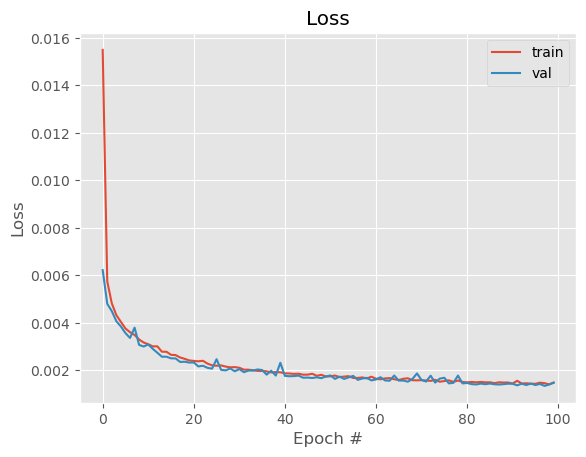

In [34]:
# Representación del loss
N = len(autoencoder_history.history["loss"])
plt.style.use("ggplot")

plt.plot(np.arange(0, N), autoencoder_history.history["loss"], label="train")
plt.plot(np.arange(0, N), autoencoder_history.history["val_loss"], label="val")
plt.title("Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="upper right")

plt.show()

### 4.2. Evaluación del autoencoder

La evaluación del modelo obtenido puede hacerse en este caso tanto de forma cuantitativa (calculando el MSE entre las imágenes originales y reconstruídas del conjunto de test) como cualitativa (mostrando imágenes originales y reconstruídas).

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
    <strong>Ejercicio [1 punto]:</strong> Realizar las siguientes operaciones para evaluar las prestaciones del modelo obtenido:
    <ul>
        <li>Partiendo del conjunto de test obtenido en el primer apartado de la practica:
            <ul>
                <li>Llevar a cabo el reescalado de los datos utilizando la capa <code>normalization_layer</code> tal y como se ha hecho con los conjuntos de entrenamiento y test al inicio de este bloque.</li>
                <li>Generar el conjunto de datos <code>test_data_auto</code> en el que las imágenes sean también el objetivo y substituyan a las etiquetas. </li>
            </ul></li>
        <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
        <li>Imprimir por pantalla 4 parejas de imágenes (original y reconstruída). Nota: a la hora de representar las imágenes correctamente, recordad que su rango dinámico deben ser números enteros entre 0 y 255.</li>
    </ul>
    Preguntas: ¿Consideras que la reconstrucción es adecuada? ¿Qué <i>ratio</i> de compresión se consigue con este autoencoder? Consideramos como <i>ratio</i> de compresión la relación entre el tamaño original de la imagen (224,224,3) y el de la representación más perqueña que llega a hacer el codificador (tamaño de la salida de su última capa).

In [35]:
# Normalización de los datos
normalized_test_data = test_data.map(lambda x, y: (normalization_layer(x), y))
test_data_auto = normalized_test_data.map(lambda x, y: (x, x))

In [36]:
# Evaluación del modelo
score = autoencoder.evaluate(test_data_auto, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score))

----------
Loss: 0.001493


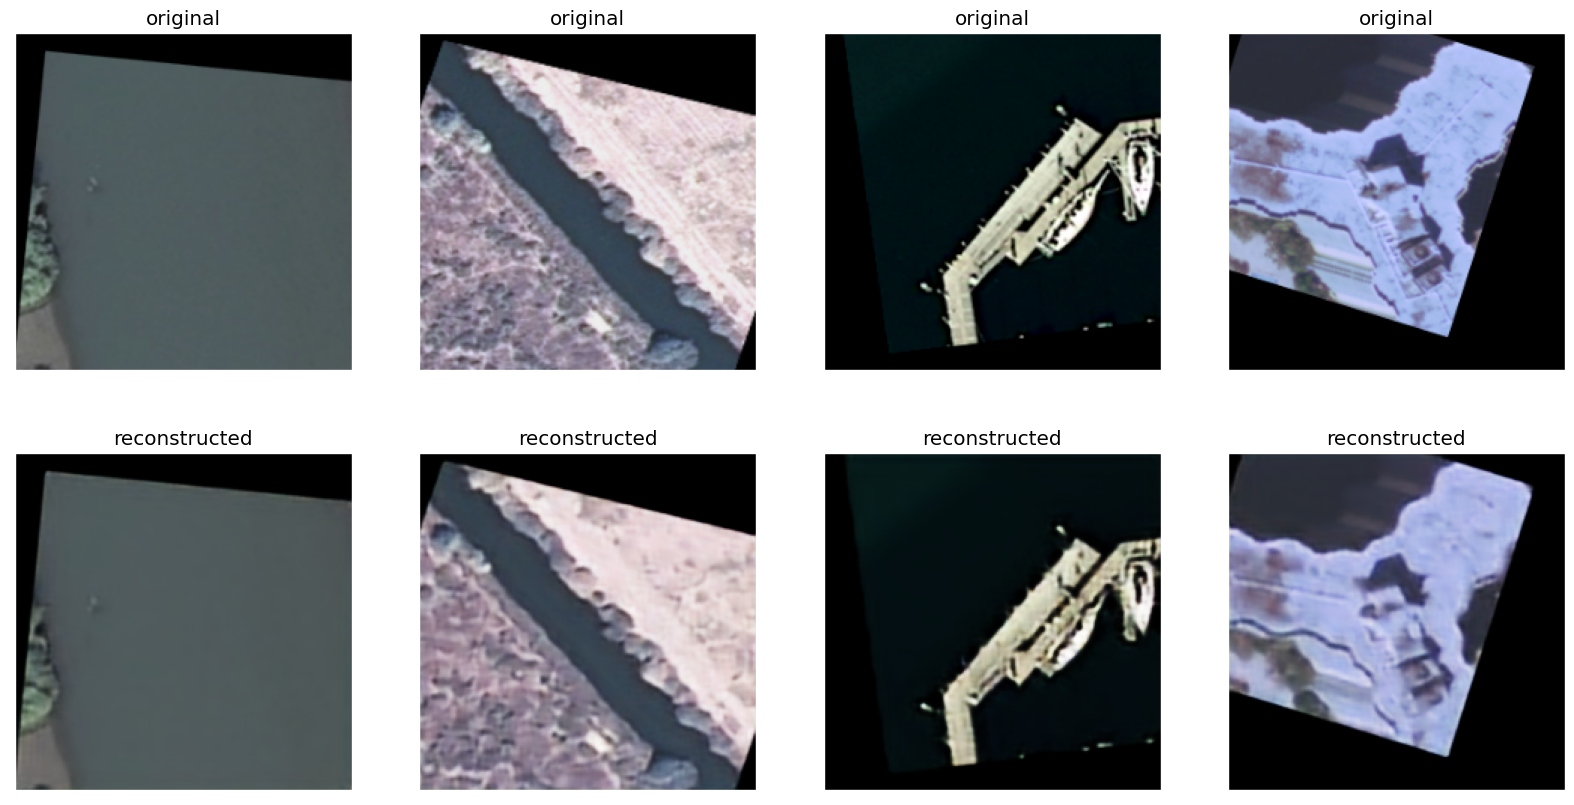

In [37]:
# Visualización de los datos

for images, labels in test_data_auto.take(1):
    pass
decoded_images = autoencoder(images).numpy()

images = images*255
decoded_images = decoded_images*255

n = 4
plt.figure(figsize=(20, 10))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_images[i].astype("uint8"))
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    <ul>
        <li> Viendo el MSE de validación obtenido (0.001493) y la calidad de las imágenes reconstruidas, puede considerrase que la reconstrucción es adecuada.</li>
        <li> El ratio de compresión es de 1/3: (224x224x3)/(28x28x64)</li>
    </ul>
</div>

## 5. Red VGG16 y transfer learning (2 puntos)

Las redes neuronales convolucionales profundas nos brindan la posibilidad de mejorar la capacidad de aprendizaje de un modelo. Algunas arquitecturas comunes, pueden incluir cientos de capas convolucionales. No obstante, entrenar estas arquitecturas desde cero puede resultar costoso tanto en términos de tiempo como de recursos, además de requerir conjuntos de datos bastante grandes.

### 5.1. Transfer Learning
En este apartado, aplicaremos [transfer learning](https://keras.io/guides/transfer_learning/) con el fin de ahorrarnos parte de dicho entrenamiento. Esta metodología consiste en aprovechar los pesos de un modelo entrenado en otra base de datos y para otra tarea. En concreto, utilizaremos el modelo [VGG16](https://keras.io/api/applications/vgg/#vgg16-function) preentrenado en [Imagenet](http://www.image-net.org/), y lo adaptaremos para clasificar las 21 categorías de nuestra base de datos. En la versión de VGG16 de keras existe la opción de cargar los pesos entrenados en Imagenet sin las 3 capas totalmente conectadas de la parte final de la red (opción <code>include_top = False</code>), nosotros substituiremos esas 3 capas y reentrenaremos el conjunto con el resto de pesos congelados.

Para reutilizar el modelo correctamente es necesario preprocesar los datos tal y como se hizo durante el entrenamiento en la base de datos original. Keras nos facilita aplicar la normalización en el caso de modelos preentrenados; para el caso de VGG16 revisar la documentación de [prepocess_input](https://www.tensorflow.org/api_docs/python/tf/keras/applications/vgg16/preprocess_input) (tened en cuenta que la función se aplica sobre imágenes con rango dinámico de 0 a 255).


<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementa una red siguiendo los siguientes pasos:
    <ul>
        <li>Partir del modelo VGG16 con los pesos entrenados en Imagenet y congelarlos</li>
        <li>Substituir las 3 últimas capas completamente conectadas por 3 capas nuevas: las 2 primeras de 50 y 20 neuronas respectivamente con activación ReLU, y una última capa con el número de neuronas adecuado para llevar a cabo la tarea de clasificación sobre nuestra base de datos y la función de activación adecuada.</li> 
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.0001.</li>
         <li>Entrenar durante 100 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas, monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorear la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados.
</div>

In [38]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input

## Loading VGG16 model
base_model = VGG16(weights="imagenet", include_top=False, input_shape=(224,224,3))
base_model.trainable = False ## Not trainable weights
base_model.summary()

58889256/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [39]:
# Definición de la red
input_layer = keras.Input(shape=(224, 224, 3), name="image")
x = preprocess_input(input_layer)
x = base_model(x, training = False)
x = Flatten()(x)
x = Dense(50, activation='relu')(x)
x = Dense(20, activation='relu')(x)
x = Dense(21, activation='softmax')(x)

vgg_model = keras.Model(inputs=[input_layer], outputs=[x])
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                1254450   
                                                           

In [40]:
# Compilación de la red
opt = Adam(learning_rate=0.0001)
vgg_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])

stopping = EarlyStopping(monitor='val_accuracy', patience=10,  restore_best_weights=True)


In [41]:
# Entrenamiento de la red
t = time.time()
vgg_history = vgg_model.fit(train_data,
                            validation_data=val_data,
                            epochs=100,
                            callbacks=stopping)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/100
230/230 [==============================] - 36s 140ms/step - loss: 2.5314 - accuracy: 0.2494 - val_loss: 1.6575 - val_accuracy: 0.5138
Epoch 2/100
230/230 [==============================] - 28s 118ms/step - loss: 1.0730 - accuracy: 0.6676 - val_loss: 1.1088 - val_accuracy: 0.6800
Epoch 3/100
230/230 [==============================] - 28s 117ms/step - loss: 0.4632 - accuracy: 0.8626 - val_loss: 0.9537 - val_accuracy: 0.7452
Epoch 4/100
230/230 [==============================] - 28s 120ms/step - loss: 0.2018 - accuracy: 0.9514 - val_loss: 0.8621 - val_accuracy: 0.7795
Epoch 5/100
230/230 [==============================] - 28s 118ms/step - loss: 0.0916 - accuracy: 0.9835 - val_loss: 0.8059 - val_accuracy: 0.7943
Epoch 6/100
230/230 [==============================] - 28s 120ms/step - loss: 0.0478 - accuracy: 0.9933 - val_loss: 0.8246 - val_accuracy: 0.8005
Epoch 7/100
230/230 [==============================] - 28s 119ms/step - loss: 0.0267 - accuracy: 0.9966 - val_loss: 0.8448 -

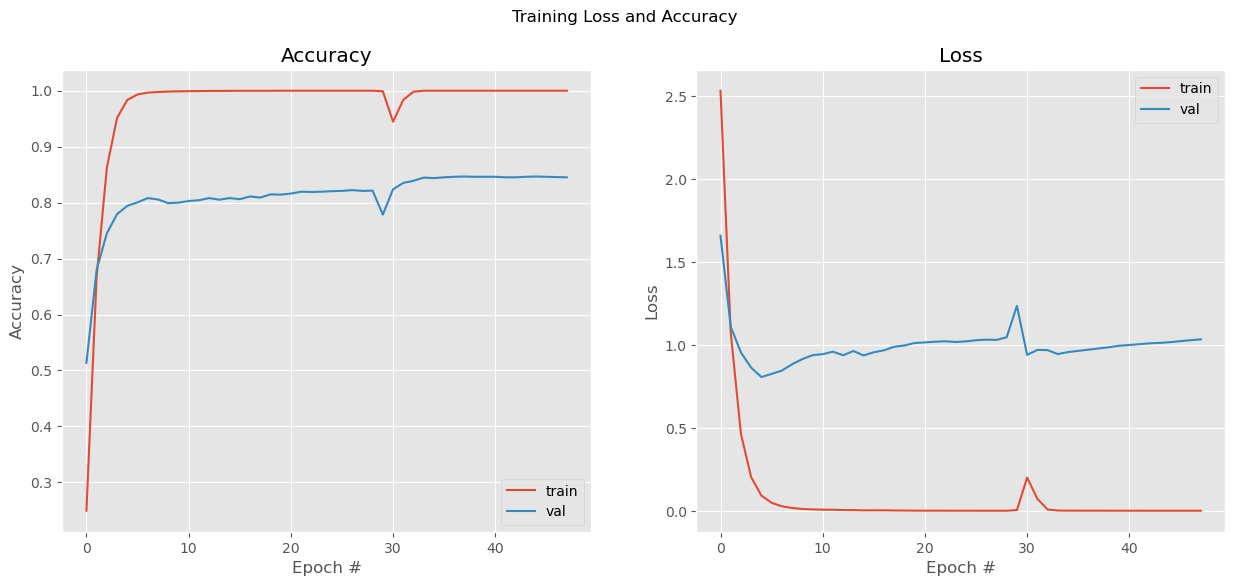

----------
Loss: 0.952226
Accuracy: 0.850476


In [42]:
# Resultados
n_epochs = len(vgg_history.history["loss"])
plot_training(n_epochs, vgg_history)

score = vgg_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Los resultados obtenidos son:
    <ul>
        <li> Número de parámetros a entrenar: 1,255,911</li>
        <li> Tiempo de entrenamiento: 1483 segundos (finaliza en 48 épocas)</li>
        <li> Accuracy: 85,05 %</li>
    </ul>
    Los resultados son bastante buenos, similares a los de la red del apartado 3. Los pesos preentrenados de la red VGG16 funcionan como un buen bloque extractor, y sólo se ha tenido que entrenar el bloque clasificador para obtener un buen resultado.
</div>

### 5.2. Fine-tunning
Una técnica frecuente, sobretodo cuando la red utilizada no es excesivamente grande (como es el caso de VGG16), para mejorar los resultados del <i>transfer learning</i> es el denominado <i>fine-tunning</i>,  que consiste en reentrenar la red completa durante unas pocas épocas y con un <i>learning rate</i> muy pequeño.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Volver a compilar el modelo con los siguientes cambios:
    <ul>
        <li>Descongelar los pesos del modelo VGG16 poniendo <code>trainable=False</code> (no confundir con <code>traning=False</code>).</li>
    </ul>
Compilar y entrenar el modelo siguiendo las siguientes indicaciones:
     <ul>
         <li>Utilizar el optimizador Adam con  <i>learning rate</i> de 0.00001.</li>
         <li>Entrenar durante 10 épocas utilizando  <i>EarlyStopping</i> con una persistencia de 10 épocas monitorizando la <i>accuracy</i> en el conjunto de validación, y guardando los pesos que mejor resultado hayan obtenido.</li>
         <li>Monitorizar la métrica  <i>accuracy</i> durante entrenamiento y validación.</li>
         <li>Mostrar las gráficas de accuracy y loss. En cada gráfica debe visualizarse la curva de entrenamiento y la de validación.</li>
         <li>Realizar la evaluación del modelo una vez ha finalizado el entrenamiento para mostrar la pérdida y la precisión final a partir de los datos de test.</li>
    </ul>
    Preguntas a responder: ¿Cúal es el número de parámetros a entrenar? ¿y el tiempo de entrenamiento? ¿Qué precisión se obtiene con este modelo? Comenta los resultados teniendo en cuenta el proceso global: <i>transfer lerning</i> + <i> fine-tunning</i>.
</div>


In [43]:
# Definición del modelo
base_model.trainable = True
vgg_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 25088)             0         
                                                                 
 dense_2 (Dense)             (None, 50)                1254450   
                                                           

In [44]:
# Compilación de la red
opt = Adam(learning_rate=0.00001)
vgg_model.compile(
    optimizer=opt,
    loss='categorical_crossentropy',
    metrics=['accuracy'])
stopping = EarlyStopping(monitor='val_accuracy', patience=10,  restore_best_weights=True)

In [46]:
# Entrenamiento
t = time.time()
fine_vgg_history = vgg_model.fit(train_data, validation_data=val_data, epochs=10, callbacks=stopping)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/10
230/230 [==============================] - 59s 243ms/step - loss: 0.0613 - accuracy: 0.9850 - val_loss: 0.9921 - val_accuracy: 0.8248
Epoch 2/10
230/230 [==============================] - 55s 237ms/step - loss: 0.0475 - accuracy: 0.9859 - val_loss: 0.7872 - val_accuracy: 0.8681
Epoch 3/10
230/230 [==============================] - 55s 236ms/step - loss: 0.0219 - accuracy: 0.9933 - val_loss: 0.7469 - val_accuracy: 0.8776
Epoch 4/10
230/230 [==============================] - 55s 238ms/step - loss: 0.0177 - accuracy: 0.9952 - val_loss: 0.7709 - val_accuracy: 0.8762
Epoch 5/10
230/230 [==============================] - 56s 240ms/step - loss: 0.0373 - accuracy: 0.9907 - val_loss: 0.6426 - val_accuracy: 0.8848
Epoch 6/10
230/230 [==============================] - 56s 239ms/step - loss: 0.0266 - accuracy: 0.9914 - val_loss: 0.8053 - val_accuracy: 0.8762
Epoch 7/10
230/230 [==============================] - 55s 238ms/step - loss: 0.0212 - accuracy: 0.9950 - val_loss: 0.6617 - val_ac

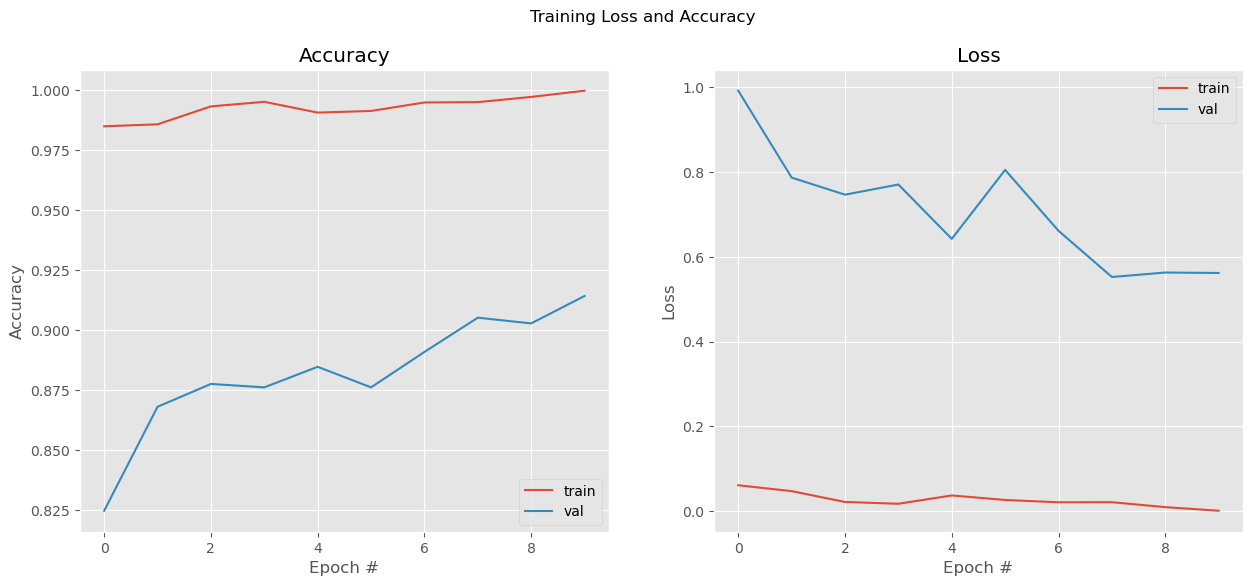

----------
Loss: 0.555825
Accuracy: 0.909524


In [47]:
# Resultados
n_epochs = len(fine_vgg_history.history["loss"])
plot_training(n_epochs, fine_vgg_history)

score = vgg_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>
    Los resultados obtenidos son:
    <ul>
        <li> Número de parámetros a entrenar: 15,970,599</li>
        <li> Tiempo de entrenamiento: parte final (sólo 10 épocas) 611 segundos, pero en total 1,483 + 611 = 2,094 segundos</li>
        <li> Accuracy: 90.95%</li>
    </ul>
    Realizando el fine-tunning y entrenado la red completa tan sólo 10 épocas conseguimos incrementar la <i>accuracy</i> casi en un 6%.
</div>

## 6. Mejora de resultados (1 punto)

En este último apartado se deja libertad al alumno para conseguir, mediante el diseño de una red propia, unos mejores resultados en la tarea de clasificación.

Se valorarará la justificación de las elecciones realizadas.

<div style="background-color: #EDF7FF; border-color: #7C9DBF; border-left: 5px solid #7C9DBF; padding: 0.5em;">
<strong>Ejercicio[1 punto]:</strong> Implementar un modelo para llevar a cabo la tarea de clasificación:
    <ul>
        <li>Diseñar la arquitectura de la red</li>
        <li>Compilar el modelo</li>
        <li>Llevar a cabo el entrenamientio</li>
        <li>Evaluar el modelo presentando las métricas y gráficas adecuadas</li>
        <li>Comentar los resultados obtenidos</li>
    </ul>
</div>

In [48]:
final_model = keras.Sequential()

final_model.add(Conv2D(32,5,
                activation="relu",
                input_shape=(224,224,3)))
final_model.add(BatchNormalization())
final_model.add(MaxPooling2D((2)))

#
final_model.add(Conv2D(64,3,
                 activation="relu"))
final_model.add(MaxPooling2D((2)))
final_model.add(Conv2D(128,3,
                 activation="relu"))
final_model.add(MaxPooling2D((2)))

#
final_model.add(Conv2D(128,3,
                 activation="relu"))
final_model.add(MaxPooling2D((2)))
final_model.add(Conv2D(128,3,
                 activation="relu"))
final_model.add(GlobalAveragePooling2D())


#
final_model.add(Flatten())
final_model.add(Dense(256,
                activation="relu"))
final_model.add(Dropout(0.5))
final_model.add(Dense(21,
                activation="softmax"))

final_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 220, 220, 32)      2432      
                                                                 
 batch_normalization (BatchN  (None, 220, 220, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 110, 110, 32)     0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 108, 108, 64)      18496     
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 54, 54, 64)       0         
 g2D)                                                            
                                                      

In [49]:
stopping =  EarlyStopping(monitor='val_loss',
                            patience=10, 
                            verbose=1, 
                            restore_best_weights=True)
opt = Adam(learning_rate=0.0001)
final_model.compile(optimizer=opt,
                    loss="categorical_crossentropy",
                    metrics=["accuracy"])


In [50]:
t = time.time()
final_model_history = final_model.fit(train_data,
                                       validation_data=val_data,
                                       callbacks=stopping,
                                       epochs=150)
print ("Tiempo de entrenamiento: ",time.time() - t, "segundos.")

Epoch 1/150
230/230 [==============================] - 29s 119ms/step - loss: 2.8105 - accuracy: 0.1412 - val_loss: 2.4133 - val_accuracy: 0.2657
Epoch 2/150
230/230 [==============================] - 27s 115ms/step - loss: 2.2990 - accuracy: 0.2916 - val_loss: 2.0006 - val_accuracy: 0.3886
Epoch 3/150
230/230 [==============================] - 27s 115ms/step - loss: 2.0124 - accuracy: 0.3746 - val_loss: 1.9463 - val_accuracy: 0.3843
Epoch 4/150
230/230 [==============================] - 28s 118ms/step - loss: 1.8250 - accuracy: 0.4188 - val_loss: 1.7183 - val_accuracy: 0.4686
Epoch 5/150
230/230 [==============================] - 27s 116ms/step - loss: 1.7002 - accuracy: 0.4604 - val_loss: 1.6330 - val_accuracy: 0.4781
Epoch 6/150
230/230 [==============================] - 27s 113ms/step - loss: 1.5808 - accuracy: 0.4901 - val_loss: 1.4719 - val_accuracy: 0.5386
Epoch 7/150
230/230 [==============================] - 27s 116ms/step - loss: 1.4851 - accuracy: 0.5201 - val_loss: 1.4595 -

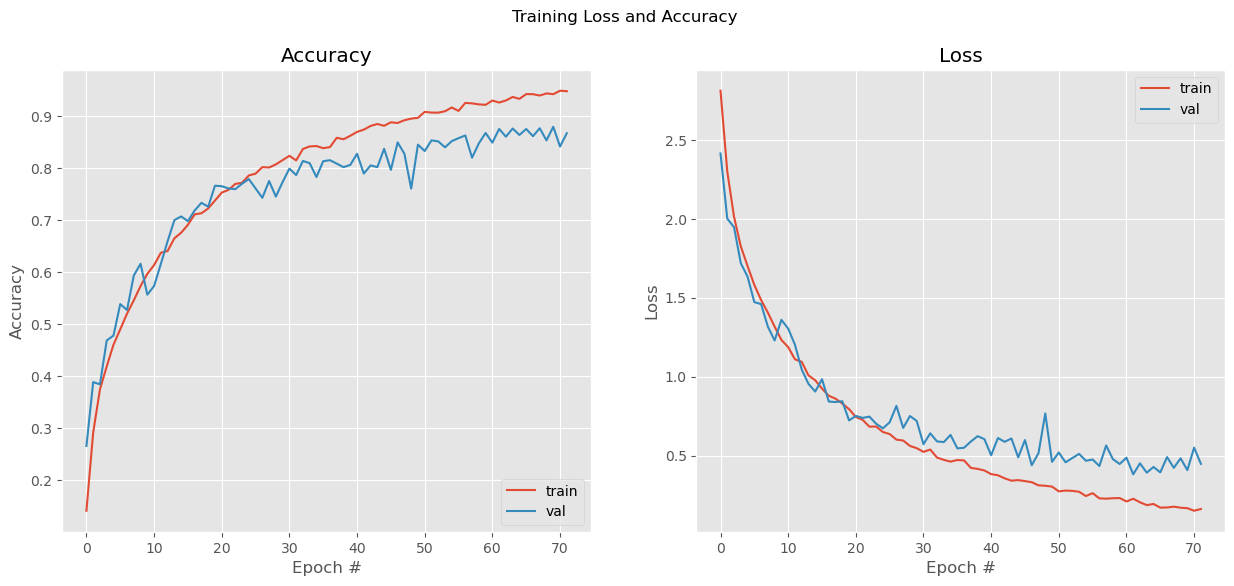

----------
Loss: 0.370209
Accuracy: 0.880952


In [51]:
n_epochs = len(final_model_history.history["loss"])
plot_training(n_epochs, final_model_history)

score = final_model.evaluate(test_data, verbose=0)
print ("-"*10)
print ("Loss: %f"%(score[0]))
print ("Accuracy: %f"%(score[1]))

<div style="background-color: #fcf2f2; border-color: #dfb5b4; border-left: 5px solid #dfb5b4; padding: 0.5em;">
<strong>Comentarios:</strong>
<br><br>Los cambios llevados a cabos son los siguientes:
    <ul>
        <li>Se ha decidido incrementar la profundidad de la red (comparada con la del apartado 3) ya que al ver los resultados obtenidos por la red VGG16 se piensa que entrenando una red de tamaño intermedio desde cero se pueden conseguir buenos resultados.</li>
        <li>Se incrementa el número de epochs ya que, al aumentar la profundidad de la red, es de esperar que el entrenamiento sea más lento.</li>
    </ul>
    Los resultados obtenidos son:
    <ul>
        <li> Número de parámetros a entrenar: 428,437</li>
        <li> Tiempo de entrenamiento: 2,125 segundos (72 épocas)</li>
        <li> Accuracy: 88,1 %</li>
    </ul>
    Se consigue incrementar el rendimiento de la red del apartado 3 en un 3-5% dependiendo de la ejecución.
</div>